# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [848]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy.stats import chi2_contingency

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [815]:
websites = pd.read_csv('../website.csv')

#### Explore the data from a bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

# MI COMENTARIO

### Como estas instrucciones ↑ dicen que no nos van a proveer las instrucciones paso a paso y que las debemos hacer la limpieza por nuestra cuenta, me he puesto directamente a preparar el dataset para introducirlo en el modelo, y he visto después en el C3 que sí que te da instrucciones concretas para preparar el dataset.

### He adaptado mi preparación del dataset a las instrucciones del C3, C4 y C5.

In [816]:
# Your code here

print("Shape:", websites.shape)
print("································")
display(websites.head())
print("································")
print("································")
print(websites.dtypes)
print("································")
print("Types:", list(websites["Type"].unique()))

Shape: (1781, 21)
································


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


································
································
URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
WHOIS_STATEPRO                object
WHOIS_REGDATE                 object
WHOIS_UPDATED_DATE            object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object
································
Types: [1, 0]


Para mi modelo voy a utilizar la variable Type como groundtruth, y voy a usar el resto como features para predecir si la web es maligna (1) o benigna (1).

Aquí he comprobado si 1 es maligno o benigno: 
https://www.kaggle.com/shikhar14cse/learning-model-using-sklearn/data

In [817]:
# Miro a ver dónde tengo valores nulos.

null_cols = websites.isnull().sum()
null_cols[null_cols > 0]

SERVER               1
CONTENT_LENGTH     812
DNS_QUERY_TIMES      1
dtype: int64

#### NULOS

In [818]:
# Casi la mitad de los valores de mi columna CONTENT_LENGTH son nulos. Por tanto, no me puede
# aportar mucho, así que me deshago de ella.

websites.drop("CONTENT_LENGTH", axis = 1, inplace = True)

# Los dos registros que son nulos en server o dns query times los quito también ya que no 
# me sirven los nulos para mi modelo y eliminar dos registros no va a afectar apenas.

websites.dropna(inplace = True)

In [819]:
# Hay varias variables cuyos valores no son numéricos. Voy a ojearlas para decidir si me 
# sirven (y si las convierto a dummies o cambio sus valores por números) o no (y me deshago de ellas).
# También tendré que convertir a ordinales las fechas (WHOIS_REGDATE y WHOIS_UPDATED_DATE).

#### URL

In [820]:
# Analizo la columna URL

print(len(websites["URL"].unique()))

# Demasiados valores categóricos distintos. Me deshago de ella.

websites.drop("URL", axis = 1, inplace = True)

1779


#### CHARSET

In [821]:
# Analizo la columna CHARSET

print(websites["CHARSET"].unique())
websites["CHARSET"].value_counts()

['iso-8859-1' 'UTF-8' 'us-ascii' 'ISO-8859-1' 'utf-8' 'None'
 'windows-1251' 'ISO-8859' 'windows-1252']


UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
windows-1252      1
windows-1251      1
ISO-8859          1
Name: CHARSET, dtype: int64

In [822]:
# Veo que hay valores que quieren decir lo mismo pero que están escritos de forma distinta. Lo corrijo.

# Creo un diccionario con los valores y sus correspondientes correcciones.

charsets = {"utf-8": "UTF-8_CHAR", "iso-8859-1": "ISO-8859-1_CHAR", "ISO-8859": "ISO-8859-1_CHAR", 
            "windows-1251": "windows_CHAR", "windows-1252": "windows_CHAR", "None": "Anonymus charset"}

# Defino una función para corregir los valores.

def unify_charsets(c):
    if c in charsets:
        return charsets.get(c)
    else:
        return c + "_CHAR"

# Aplico la función a toda la columna.

websites["CHARSET"] = websites["CHARSET"].apply(unify_charsets)

websites["CHARSET"].value_counts()

UTF-8_CHAR          1053
ISO-8859-1_CHAR      562
us-ascii_CHAR        155
Anonymus charset       7
windows_CHAR           2
Name: CHARSET, dtype: int64

In [823]:
# Ahora puedo hacer dummies con la columna CHARSET.

for cs in websites["CHARSET"].unique():
    websites[cs] = websites["CHARSET"].str.contains(cs, regex = False).astype(int)
    
websites.drop("CHARSET", axis = 1, inplace = True)
websites.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,ISO-8859-1_CHAR,UTF-8_CHAR,us-ascii_CHAR,Anonymus charset,windows_CHAR
0,16,7,nginx,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1,1,0,0,0,0
1,16,6,Apache/2.4.10,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,1,0,0,0
2,16,6,Microsoft-HTTPAPI/2.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0
3,17,6,nginx,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0,1,0,0,0,0
4,17,6,None,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,1,0,0,0


#### SERVER

In [824]:
# Analizo la columna SERVER

print(websites["SERVER"].unique()[:10])

['nginx' 'Apache/2.4.10' 'Microsoft-HTTPAPI/2.0' 'None' 'Apache/2'
 'nginx/1.10.1' 'Apache' 'Apache/2.2.15 (Red Hat)'
 'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4'
 'openresty/1.11.2.1']


In [825]:
# Veo que los valores se pueden reducir a 4 principales: ["Microsoft", "Apache", "nginx", "Other"]

# Defino una función que los convierta

def simplify_server(s):
    if "Microsoft" in s:
        return "Microsoft_SER"
    elif "Apache" in s:
        return "Apache_SER"
    elif "nginx" in s:
        return "nginx_SER"
    else:
        return "Other server"     

websites["SERVER"] = websites["SERVER"].apply(simplify_server)

websites["SERVER"].value_counts()

Apache_SER       642
Other server     504
nginx_SER        435
Microsoft_SER    198
Name: SERVER, dtype: int64

In [826]:
# Igual que he hecho con CHARSET, convierto SERVER a dummies:

for ser in websites["SERVER"].unique():
    websites[ser] = websites["SERVER"].str.contains(ser, regex = False).astype(int)
    
websites.drop("SERVER", axis = 1, inplace = True)
websites.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,ISO-8859-1_CHAR,UTF-8_CHAR,us-ascii_CHAR,Anonymus charset,windows_CHAR,nginx_SER,Apache_SER,Microsoft_SER,Other server
0,16,7,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1,1,0,0,0,0,1,0,0,0
1,16,6,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,1,0,0,0,0,1,0,0
2,16,6,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,1,0
3,17,6,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0,1,0,0,0,0,1,0,0,0
4,17,6,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,1,0,0,0,0,0,0,1


#### WHOIS_COUNTRY

In [827]:
# Analizo la columna WHOIS_COUNTRY

print(websites["WHOIS_COUNTRY"].unique())
print(websites["WHOIS_COUNTRY"].value_counts()[:15])

['None' 'US' 'SC' 'GB' 'UK' 'RU' 'AU' 'CA' 'PA' 'se' 'IN' 'LU' 'TH'
 "[u'GB'; u'UK']" 'FR' 'NL' 'UG' 'JP' 'CN' 'SE' 'SI' 'IL' 'ru' 'KY' 'AT'
 'CZ' 'PH' 'BE' 'NO' 'TR' 'LV' 'DE' 'ES' 'BR' 'us' 'KR' 'HK' 'UA' 'CH'
 'United Kingdom' 'BS' 'PK' 'IT' 'Cyprus' 'BY' 'AE' 'IE' 'UY' 'KG']
US      1102
None     306
CA        83
ES        63
AU        35
PA        21
GB        19
JP        11
CN        10
UK        10
IN        10
FR         9
CZ         9
CH         6
NL         6
Name: WHOIS_COUNTRY, dtype: int64


In [828]:
# Corrijo los valores mal escritos:

correcciones = {"us": "US_CNTY", "Cyprus": "CY_CNTY", "United Kingdom": "GB_CNTY", 
                "[u'GB'; u'UK']": "GB_CNTY", "None": "Anonymus country"}

def corrige_pais(p):
    if p in correcciones:
        return correcciones.get(p)
    else:
        return p + "_CNTY"

websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].apply(corrige_pais)

# Me quedo con los top10 países y marco el resto como "Other"

def top10(c):
    if c in websites["WHOIS_COUNTRY"].value_counts()[:10]:
        return c
    else:
        return "Other country"

websites["WHOIS_COUNTRY"] = websites["WHOIS_COUNTRY"].apply(top10)

# No modifico los valores "None", porque es posible que sean así porque son 
# resgistros anónimos, y eso puede que influya en la malignidad de la URL. 
# Por tanto, ni los borro, ni los convierto en Other.

print(websites["WHOIS_COUNTRY"].value_counts())

US_CNTY             1105
Anonymus country     306
Other country        110
CA_CNTY               83
ES_CNTY               63
AU_CNTY               35
GB_CNTY               25
PA_CNTY               21
JP_CNTY               11
UK_CNTY               10
CN_CNTY               10
Name: WHOIS_COUNTRY, dtype: int64


In [829]:
# Igual que he hecho con CHARSET y SERVER, convierto WHOIS_COUNTRY a dummies:

for c in websites["WHOIS_COUNTRY"].unique():
    websites[c] = websites["WHOIS_COUNTRY"].str.contains(c, regex = False).astype(int)
    
websites.drop("WHOIS_COUNTRY", axis = 1, inplace = True)
websites.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,ISO-8859-1_CHAR,UTF-8_CHAR,us-ascii_CHAR,Anonymus charset,windows_CHAR,nginx_SER,Apache_SER,Microsoft_SER,Other server,Anonymus country,US_CNTY,Other country,GB_CNTY,UK_CNTY,AU_CNTY,CA_CNTY,PA_CNTY,JP_CNTY,CN_CNTY,ES_CNTY
0,16,7,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,16,6,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,16,6,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,17,6,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,17,6,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


#### WHOIS_STATEPRO

In [830]:
# Analizo la columna WHOIS_STATEPRO

print(websites["WHOIS_STATEPRO"].unique()[:10])

['None' 'AK' 'TX' 'Mahe' 'CO' 'FL' 'Kansas' 'Novosibirskaya obl.' 'CA'
 'Tennessee']


In [831]:
# Demasiados valores categóricos complejos para mi modelo. Me deshago de la columna.

websites.drop("WHOIS_STATEPRO", axis = 1, inplace = True)

#### WHOIS_REGDATE y WHOIS_UPDATED_DATE

In [832]:
# Tengo que convertir los valores de las fechas a ordinales.

from datetime import datetime as dt

def date_toord(date):
    if date == "None":
        return None
    elif date == "2002-03-20T23:59:59.0Z":
        return dt.strptime(str("20/03/2002 23:59"), "%d/%m/%Y %H:%M").date().toordinal()
    else:
        a = dt.strptime(str(date), "%d/%m/%Y %H:%M").date()
        return a.toordinal()

# websites["WHOIS_REGDATE"] = websites["WHOIS_REGDATE"].apply(date_toord)

# WHOIS_REGDATE me está dando demasiados problemas, porque tiene muchos valores sucios. 
# Por tanto me voy a deshacer de ella.

websites.drop("WHOIS_REGDATE", axis = 1, inplace = True)

# Pruebo con WHOIS_UPDATED_DATE

# websites["WHOIS_UPDATED_DATE"] = websites["WHOIS_UPDATED_DATE"].apply(date_toord)

# Me da problemas también, así que me deshago de ella de la misma forma.

websites.drop("WHOIS_UPDATED_DATE", axis = 1, inplace = True)

In [833]:
websites.dtypes

URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
REMOTE_APP_BYTES               int64
APP_PACKETS                    int64
DNS_QUERY_TIMES              float64
Type                           int64
ISO-8859-1_CHAR                int64
UTF-8_CHAR                     int64
us-ascii_CHAR                  int64
Anonymus charset               int64
windows_CHAR                   int64
nginx_SER                      int64
Apache_SER                     int64
Microsoft_SER                  int64
Other server                   int64
Anonymus country               int64
US_CNTY                        int64
Other country                  int64
GB_CNTY                        int64
UK_CNTY                        int64
A

#### DNS_QUERY_TIMES

In [834]:
# Por perfeccionismo y por si acaso, convierto DNS_QUERY_TIMES también a entero

for i in websites["DNS_QUERY_TIMES"]:
    decimals = str(i)[str(i).index(".") +1:]
    dec_digits = []
    for e in decimals:
        dec_digits.append(int(e))
    if sum(dec_digits) != 0:
        print(i)

In [835]:
# Tras comprobar que ninguno de los valores de DNS_QUERY_TIMES tiene decimales distintos de cero, 
# convierto directamente a enteros:

def convert_toint(x):
    return int(x)

websites["DNS_QUERY_TIMES"] = websites["DNS_QUERY_TIMES"].apply(convert_toint)

In [836]:
print(websites.shape)
print(websites.dtypes)
websites.head()

(1779, 33)
URL_LENGTH                   int64
NUMBER_SPECIAL_CHARACTERS    int64
TCP_CONVERSATION_EXCHANGE    int64
DIST_REMOTE_TCP_PORT         int64
REMOTE_IPS                   int64
APP_BYTES                    int64
SOURCE_APP_PACKETS           int64
REMOTE_APP_PACKETS           int64
SOURCE_APP_BYTES             int64
REMOTE_APP_BYTES             int64
APP_PACKETS                  int64
DNS_QUERY_TIMES              int64
Type                         int64
ISO-8859-1_CHAR              int64
UTF-8_CHAR                   int64
us-ascii_CHAR                int64
Anonymus charset             int64
windows_CHAR                 int64
nginx_SER                    int64
Apache_SER                   int64
Microsoft_SER                int64
Other server                 int64
Anonymus country             int64
US_CNTY                      int64
Other country                int64
GB_CNTY                      int64
UK_CNTY                      int64
AU_CNTY                      int64
CA_CNTY  

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type,ISO-8859-1_CHAR,UTF-8_CHAR,us-ascii_CHAR,Anonymus charset,windows_CHAR,nginx_SER,Apache_SER,Microsoft_SER,Other server,Anonymus country,US_CNTY,Other country,GB_CNTY,UK_CNTY,AU_CNTY,CA_CNTY,PA_CNTY,JP_CNTY,CN_CNTY,ES_CNTY
0,16,7,7,0,2,700,9,10,1153,832,9,2,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,16,6,17,7,4,1230,17,19,1265,1230,17,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,16,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,17,6,31,22,3,3812,39,37,18784,4380,39,8,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,17,6,57,2,5,4278,61,62,129889,4586,61,4,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

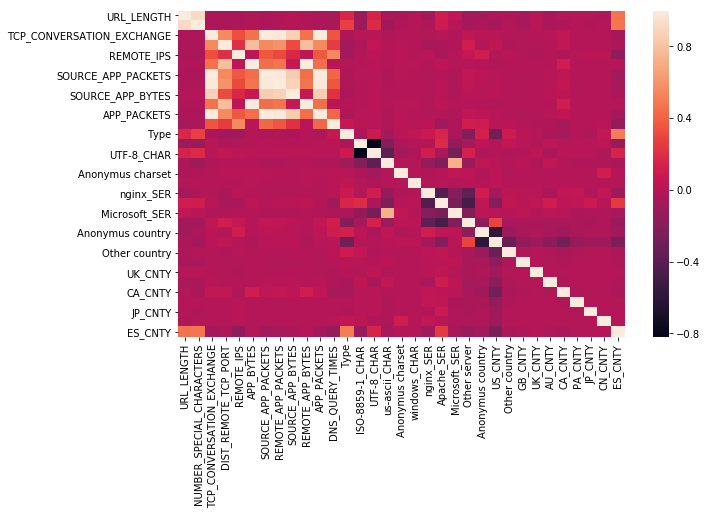

In [845]:
# En lugar de la heatmap a partir de pvalues, voy a hacerlo a partir de la correlación por probar.

numeric_data = websites._get_numeric_data()
correl = numeric_data.corr()

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(correl)

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

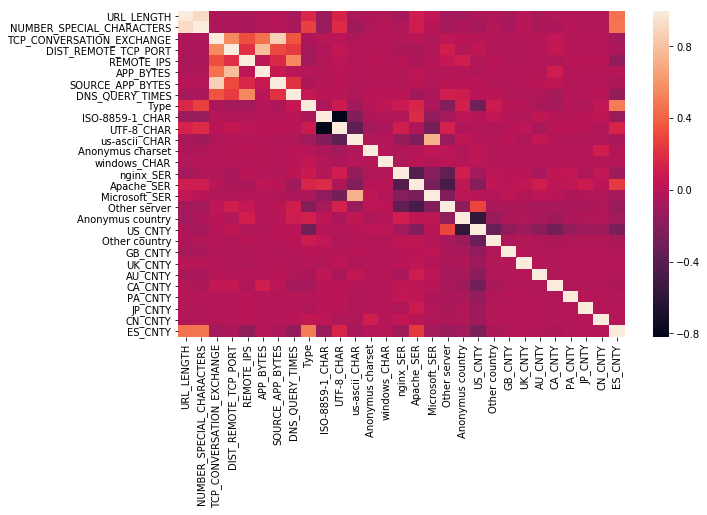

In [846]:
# Veo que TCP_CONVERSATION_EXCHANGE, SOURCE_APP_PACKETS, REMOTE_APP_PACKETS, y APP_PACKETS
# están completamente correlacionadas. Por tanto, con que me quede con una sola de esas 4 me sirve. 
# Además, APP_BYTES y REMOTE_APP_BYTES están perfectamente correlacionadas también, así que elimino 
# una de ellas.

websites.drop(["SOURCE_APP_PACKETS", "REMOTE_APP_PACKETS", "APP_PACKETS", "REMOTE_APP_BYTES"]
              , axis = 1, inplace = True)

numeric_data = websites._get_numeric_data()
correl = numeric_data.corr()

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(correl)

In [ ]:
# Como hicimos en el lab anterior, obtengo también la matriz de correlación con los pvalues 
# de las crosstables de las parejas de columnas.

def correlation_pvalue_matrix(dataset):
    columns = dataset.columns.values  
    pvalues_matrix = {}        
    
    for col1 in columns:
        pvalues_matrix[col1] = {}
        for col2 in columns:
            ct = pd.crosstab(dataset[col1], dataset[col2])
            pvalues_matrix[col1][col2] = chi2_contingency(ct)[1]
        
    return pd.DataFrame(pvalues_matrix, index = columns)

corr_matrix = correlation_pvalue_matrix(websites._get_numeric_data())

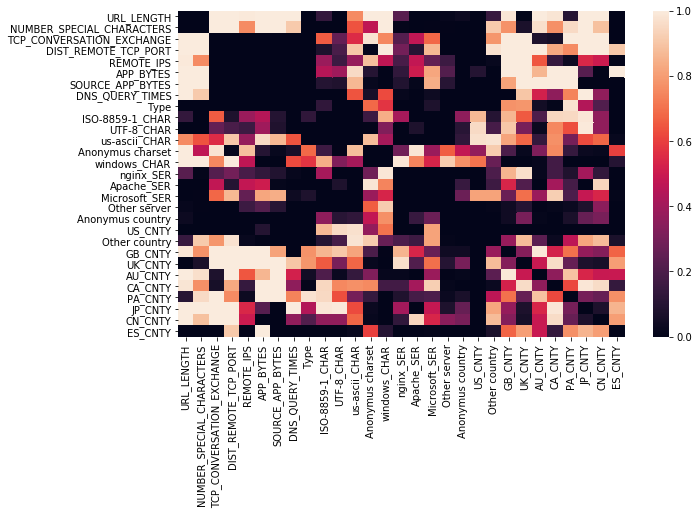

In [850]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr_matrix)

# Esta limpieza ya la tengo hecha arriba.

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [748]:
# Your code here


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [749]:
# Your code here


In [750]:
# Your comment here

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [751]:
# Examine missing values in each column


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [752]:
# Your code here


Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [753]:
# Your code here


#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [754]:
# Your code here


Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [755]:
# Your code here


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [756]:
# Your code here


#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [757]:
# Your code here


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [758]:
# Your code here

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [759]:
# Your code here


![Think Hard](../think-hard.jpg)

In [760]:
# Your comment here


Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [761]:
# Your code here


In [762]:
# Count `SERVER` value counts here


OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [763]:
# Your code here


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [764]:
# Your code here


# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [853]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [851]:
from sklearn.model_selection import train_test_split

X = websites.drop("Type", axis = 1)
y = websites["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1423, 28) (356, 28) (1423,) (356,)


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [873]:
# Your code here:

model_log = LogisticRegression(solver = "liblinear", C = 5)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [874]:
# Your code here:

model_log.fit(X_train, y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [875]:
# Your code here:

predictions = cross_val_predict(model_log, X_test, y_test, cv = 5)
cmatrix_log = confusion_matrix(y_test, predictions)
accuaracy_log = accuracy_score(y_test, predictions)

print(cmatrix_log)
print(accuaracy_log)

[[309   9]
 [ 17  21]]
0.9269662921348315


What are your thoughts on the performance of the model? Write your conclusions below.

In [769]:
# Your conclusions here:

# De las que 

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [770]:
# Your code here:



To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [771]:
# Your code here:



#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [772]:
# Your code here:



Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [773]:
# Your conclusions here:



# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [774]:
# Your code here